# Sprint 2 - Molelo de Regressão para Prever o Preço de Carros


### Descrição das Variáveis
* **manufacturer**: nome do fabricante.
* **model**: modelo do carro.
* **year**: ano de produção.
* **mileage**: número de milhas percorridas.
* **engine**: descrição do motor.
* **transmission**: tipo de transmissão.
* **drivetrain**: tipo de tração.
* **fuel_type**: tipo de combustível.
* **mpg**: milhas por galão.
* **exterior_color**: cor externa.
* **interior_color**: cor interna.
* **accidents_or_damage**: Envolvimento em acidentes (1 = sim / 0 = não).
* **one_owner**: Único dono (1 = sim / 0 = não).
* **personal_use_only**: Apenas uso pessoal (1 = sim / 0 = não).
* **seller_name**: Nome do vendedor.
* **seller_rating**: Avaliação do vendedor.
* **driver_rating**: Avaliação do carro pelos motoristas.
* **driver_reviews_num**: Número de avaliações pelos motoristas.
* **price_drop**: Redução do preço em relação ao preço inicial.
* **price**: Preço do carro.

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [10]:
training_set = pd.read_csv('cars.csv')

In [11]:
training_set.head()

,manufacturer,model,year,mileage,engine,transmission,drivetrain,fuel_type,mpg,exterior_color,interior_color,accidents_or_damage,one_owner,personal_use_only,seller_name,seller_rating,driver_rating,driver_reviews_num,price_drop,price
0,Acura,ILX Hybrid 1.5L,2013,92945.0,"1.5L I-4 i-VTEC variable valve control, engine...",Automatic,Front-wheel Drive,Gasoline,39-38,Black,Parchment,0.0,0.0,0.0,Iconic Coach,NaN,4.4,12.0,300.0,13988.0
1,Acura,ILX Hybrid 1.5L,2013,47645.0,1.5L I4 8V MPFI SOHC Hybrid,Automatic CVT,Front-wheel Drive,Hybrid,39-38,Gray,Ebony,1.0,1.0,1.0,Kars Today,NaN,4.4,12.0,NaN,17995.0
2,Acura,ILX Hybrid 1.5L,2013,53422.0,1.5L I4 8V MPFI SOHC Hybrid,Automatic CVT,Front-wheel Drive,Hybrid,39-38,Bellanova White Pearl,Ebony,0.0,1.0,1.0,Weiss Toyota of South County,4.3,4.4,12.0,500.0,17000.0
3,Acura,ILX Hybrid 1.5L,2013,117598.0,1.5L I4 8V MPFI SOHC Hybrid,Automatic CVT,Front-wheel Drive,Hybrid,39-38,Polished Metal Metallic,NaN,0.0,1.0,1.0,Apple Tree Acura,NaN,4.4,12.0,675.0,14958.0
4,Acura,ILX Hybrid 1.5L,2013,114865.0,1.5L I4 8V MPFI SOHC Hybrid,Automatic CVT,Front-wheel Drive,Hybrid,39-38,NaN,Ebony,1.0,0.0,1.0,Herb Connolly Chevrolet,3.7,4.4,12.0,300.0,14498.0


In [12]:
training_set.tail()

,manufacturer,model,year,mileage,engine,transmission,drivetrain,fuel_type,mpg,exterior_color,interior_color,accidents_or_damage,one_owner,personal_use_only,seller_name,seller_rating,driver_rating,driver_reviews_num,price_drop,price
762086,Volvo,S60 B5 Momentum,2022,22877.0,2.0L I4 16V GDI DOHC Turbo,8-Speed Automatic,All-wheel Drive,Gasoline,25-33,Bright Silver Metallic,Blond,0.0,1.0,0.0,Volvo Cars Danbury,4.2,4.2,2.0,250.0,34798.0
762087,Volvo,S60 T5,2012,72900.0,250.0HP 2.5L 5 Cylinder Engine Gasoline Fuel,A/T,Front-wheel Drive,Gasoline,NaN,Red,Beige,NaN,NaN,NaN,NaN,NaN,4.5,101.0,NaN,12500.0
762088,Volvo,S60 T5,2014,92000.0,2.5L I5 20V MPFI DOHC Turbo,6-Speed Automatic,Front-wheel Drive,Gasoline,21-30,Ice White,Soft Beige,0.0,0.0,1.0,Dapper Car Sales,NaN,4.8,36.0,300.0,12299.0
762089,Volvo,S60 T5 Platinum,2013,132000.0,2.5L I5 20V MPFI DOHC Turbo,6-Speed Automatic,All-wheel Drive,Gasoline,20-29,Ice White,Off Black,1.0,0.0,0.0,Legend Auto Sales Inc.,4.6,4.7,62.0,1000.0,8995.0
762090,Volvo,S60 T5 Premier,2015,115592.0,2.5L I5 20V MPFI DOHC Turbo,6-Speed Automatic,All-wheel Drive,Gasoline,20-29,Savile Gray Metallic,Off-Black,1.0,0.0,1.0,Plymouth Auto Sales,NaN,4.7,51.0,501.0,12999.0


In [13]:
training_set['drivetrain'].value_counts()

drivetrain
Front-wheel Drive                                              241432
All-wheel Drive                                                230219
Four-wheel Drive                                               157082
Rear-wheel Drive                                                97437
FWD                                                              6450
AWD                                                              3586
4WD                                                              1923
RWD                                                              1758
All-Wheel Drive                                                   120
Unknown                                                           105
Front-Wheel Drive                                                 104
Front-Wheel Drive with Limited-Slip Differential                   44
Four-Wheel Drive                                                   43
Four-Wheel Drive with Locking and Limited-Slip Differential        42
Rear-Whee

Como a quantidade de carros com o diferencial (locking e limited-slip) é pequena, decidi por ignorar essa funcionalidade.

In [14]:
# substituindo os valores faltantes pela moda

mode_drivetrain = training_set['drivetrain'].mode()[0]
training_set['drivetrain'] = training_set['drivetrain'].fillna(mode_drivetrain)

In [15]:
training_set['drivetrain'] = training_set['drivetrain'].apply(lambda x: 'Unknown' if 'Engine' in x else x)
# Dicionário de mapeamento para normalização
# Unknown foi substituído pela moda (FWD)
# Como só ficaremos com 3 carros 2WD, resolvi substituí-los por FWD também
drivetrain_mapping = {
    'Front-wheel Drive': 'FWD',
    'Rear-wheel Drive': 'RWD',
    'All-wheel Drive': 'AWD',
    'Four-wheel Drive': '4WD',
    'Unknown': 'FWD',
    'RWD': 'RWD',
    'FWD': 'FWD',
    'AWD': 'AWD',
    '4WD': '4WD',
    'Front-Wheel Drive': 'FWD',
    'Front Wheel Drive': 'FWD',
    'Rear-Wheel Drive': 'RWD',
    'Four-Wheel Drive': '4WD',
    'Four Wheel Drive': '4WD',
    'All Wheel Drive': 'AWD',
    '4x4': '4WD',
    '4X4': '4WD',
    '4x2': 'FWD',
    '2WD': 'FWD',
    'All-Wheel Drive': 'AWD',
    'Rear Wheel Drive': 'RWD',
    'Front-Wheel Drive with Limited-Slip Differential': 'FWD',
    'Four-Wheel Drive with Locking and Limited-Slip Differential': '4WD',
    'All-Wheel Drive with Locking and Limited-Slip Differential': 'AWD',
    'All-Wheel Drive with Locking Differential': 'AWD',
    'Rear-Wheel Drive with Limited-Slip Differential': 'RWD',
    'Four-Wheel Drive with Locking Differential': '4WD'
}

training_set['drivetrain'] = training_set['drivetrain'].replace(drivetrain_mapping)


training_set['drivetrain'].value_counts()

drivetrain
FWD    269727
AWD    233989
4WD    159126
RWD     99249
Name: count, dtype: int64

In [16]:
training_set['manufacturer'].value_counts()

manufacturer
Ford             79526
Toyota           59535
Chevrolet        56043
Nissan           48529
Jeep             41665
Mercedes-Benz    40824
Honda            37612
BMW              37570
Kia              35063
GMC              29563
Dodge            25250
Subaru           24767
Volkswagen       24620
Hyundai          22203
Lexus            21301
RAM              19364
Audi             17863
Cadillac         17794
Mazda            15485
Buick            14624
Chrysler         12647
INFINITI         12289
Land Rover       12272
Porsche          11461
Lincoln          10608
Volvo            10029
Acura             8489
Tesla             5883
Mitsubishi        5743
Jaguar            3469
Name: count, dtype: int64

In [17]:
mode_drivetrain

'Front-wheel Drive'

In [24]:
# run_times.info()

In [19]:
print(list(training_set['fuel_type'].unique()))

['Gasoline', 'Hybrid', nan, 'Premium', 'Electric', 'Gasoline/Mild Electric Hybrid', 'Diesel', 'E85 Flex Fuel', 'Flexible Fuel', 'Gasoline Fuel', 'Plug-In Hybrid', 'Premium (Required)', 'Regular Unleaded', 'Unspecified', 'Unknown', 'Compressed Natural Gas', 'Other', 'Natural Gas', 'Gaseous', 'Bi-Fuel', 'Flex Fuel Capability', 'Diesel Fuel', 'Premium Unleaded', 'Biodiesel', 'Bio Diesel', 'Hydrogen Fuel Cell', 'Gas', 'PHEV', 'Hybrid Fuel', 'Automatic', 'E85 Fl', 'Electric Fuel System', 'G', 'B', 'Gas/Electric Hybrid', 'Flex Fuel', 'Plug-In Electric/Gas']


## 1. Variáveis Categóricas e Numéricas

Importante ressaltarmos a diferença entre ambas.

* **Variáveis categóricas** – são aquelas que representam qualidade. Nesse estudo, serão consideradas categóricas as variáveis:
    * manufacturer, model, engine, transmission, drivetrain, fuel_type, exterior_color, interior_color, accidents_or_damage, one_owner, personal_use_only, seller_name.

* **Variáveis numéricas** - são as que representam quantidade. Serão assim consideradas as variáveis:
    * mileage, year, mpg, seller_rating, driver_rating, driver_reviews_num, price_drop e price.

Importante ressaltar que ano será considerado uma variável numérica dado o contexto da análise. O que será considerado para fins de análise é o envelhecimento do carro, ou seja, um dado numérico. Seria diferente, caso o ano fosse usado para agrupar os carros, ou seja, para colocá-los em categorias, então seria considerado uma variável categórica.


Vamos calcular a correlação de Pearson entre as variáveis numéricas.


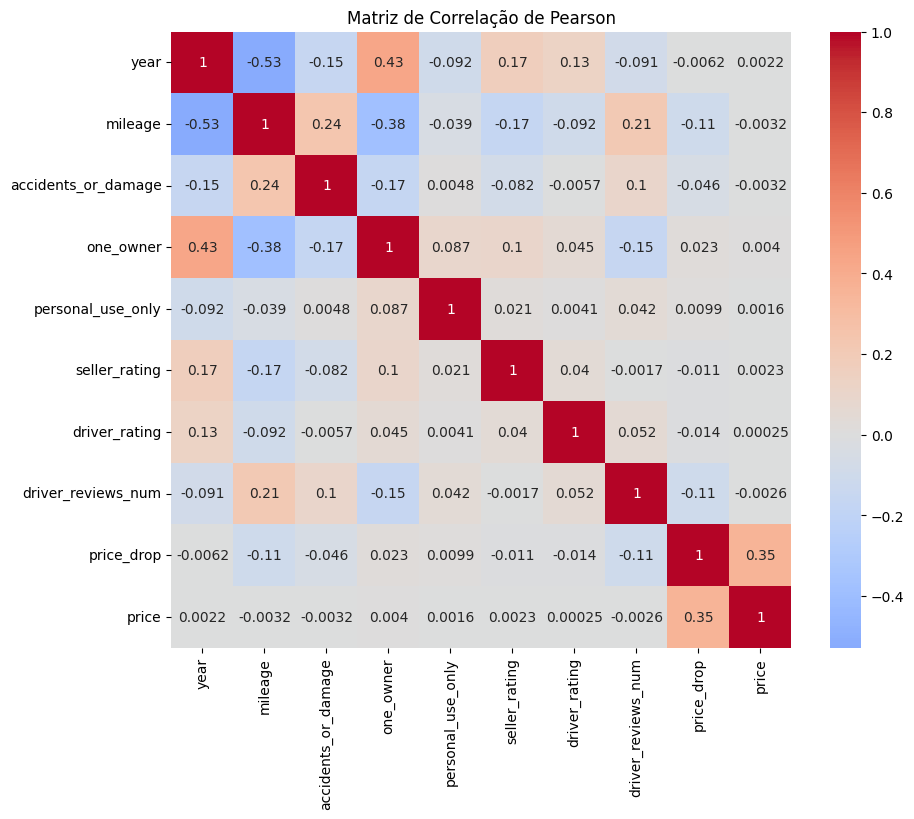

In [29]:
numeric_df = training_set.select_dtypes(include=[np.number])
correlation_matrix = numeric_df.corr(method='pearson')
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Matriz de Correlação de Pearson')
plt.show()